In [1]:
import pandas as pd
data = pd.read_feather('Feathers/processed_data.feather')
data.head()

,text,label
0,reader mail sc ruling alimony supreme court ex...,0
1,niqaab ‘ elephant courtroom ’ say uk judge per...,0
2,grandparent honoured staff student global publ...,0
3,guardian quick crossword convinced know pay news,0
4,fisherman call strike country boat fisherman p...,1


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.text, data.label, test_size=0.33, random_state=28)

In [6]:
# Grid search
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__min_df': (0.01, 0.05, 0.1, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)),  # unigrams, bigrams or trigrams
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__penalty': ('l1', 'l2'),
    'clf__loss': ('hinge', 'squared_hinge'),
    'clf__tol': (1e-4, 1e-2),
    'clf__fit_intercept': (True, False)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best score: 0.889
Best parameters set:
	clf__fit_intercept: True
	clf__loss: 'squared_hinge'
	clf__penalty: 'l2'
	clf__tol: 0.0001
	tfidf__max_df: 0.5
	tfidf__min_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__norm: 'l2'
	tfidf__smooth_idf: True
	tfidf__use_idf: True


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       308
           1       1.00      0.96      0.98        98

    accuracy                           0.99       406
   macro avg       0.99      0.98      0.99       406
weighted avg       0.99      0.99      0.99       406



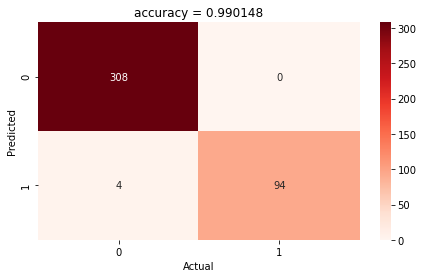

In [8]:
# Predict and report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_pred = grid_search.predict(X_train)
print(classification_report(y_train, y_pred))

conf_matrix = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(7.2,4))
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g',
            xticklabels=[0, 1], 
            yticklabels=[0, 1],
            cmap="Reds",)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('accuracy = %f' %(accuracy_score(y_train, y_pred)))
plt.show()

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       148
           1       0.85      0.67      0.75        52

    accuracy                           0.89       200
   macro avg       0.87      0.82      0.84       200
weighted avg       0.88      0.89      0.88       200



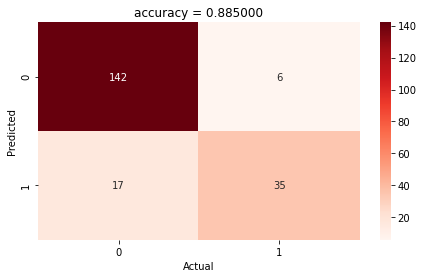

In [9]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7.2,4))
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g',
            xticklabels=[0, 1], 
            yticklabels=[0, 1],
            cmap="Reds",)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('accuracy = %f' %(accuracy_score(y_test, y_pred)))
plt.show()

In [10]:
d = {
     'Model': 'Linear Support Vector',
     'Training Set Accuracy': accuracy_score(y_train, grid_search.predict(X_train)),
     'Test Set Accuracy': accuracy_score(y_test, y_pred)
}

df_models_lsv = pd.DataFrame(d, index=[0])
df_models_lsv

,Model,Training Set Accuracy,Test Set Accuracy
0,Linear Support Vector,0.990148,0.885


In [11]:
df_models_lsv.to_feather('Feathers/Models/lsv.feather')